# Exploratory Data Analysis

In this notebook, I will conduct a high-level investigation the wrangled credit card client default data set.  From this investigation, I will try to draw some inferences and insights and create a preliminary data story.

## Main Question: What features might predict card client default?

To answer this main question, I will answer to the following related questions:

1. Is the proportion of defaults the same for men and women?
2. Is the proportion of defaults the same regardless of level of education?
3. Is the proportion of defaults the same regardless of marital status?
4. Is the proportion of defaults correlated with age?
5. Is the proportion of defaults correlated with credit limit?
6. Is the history of past repayment status predictive of the proportion of defaults?
7. Is the history of credit card bill amount predictive of the proportion of defaults?
8. Is the ratio of ((bill amount - pay amount) / credit limit) predictive of the proportion of defaults?

In [1]:
# Import libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Modify notebook settings
%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.max_columns = 100

### Create path to data file

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the wrangled data file
# "dataset_wrangled.csv"
wrangled_data_file = os.path.join(proj_root,
                                "data",
                                "interim",
                                "dataset_wrangled.csv")

### Create path to folder of exhibits for the final report

In [3]:
# Save the path to the folder that will contain 
# the figures for the final report:
# /reports/figures
figures_dir = os.path.join(proj_root,
                                "reports",
                                "figures")

### Read in wrangled data

In [4]:
# Read in the wrangled credit card client default data set.

df_wrangled = pd.read_csv(wrangled_data_file,
                          header=1, 
                          index_col=0)
#df_wrangled.head()

### 1. Is the proportion of defaults the same for men and women?

The data set contains 11888 males and 18112 females.  

There does not seem to be any reason to think that men would be more likely to default than women, or vice versa.

Below, we will check whether the proportion of defaults for men and is roughly the same as the proportion of defaults for women.

In [5]:
# Create a contingency table of 
# gender (male / female) and
# default status (default / non-default)

default_sex_crosstab = pd.crosstab(df_wrangled['default payment next month'], 
                                   df_wrangled['SEX'], 
                                   margins=True,
                                   normalize=False)

# default payment next month:
# 0 = non-default; 1 = default
new_index = {0: 'Non-default', 1: 'Default', }

# SEX: 
# 1 = male; 2 = female
new_columns = {1 : 'Male', 2 : 'Female'}

default_sex_crosstab.rename(index=new_index, columns=new_columns, inplace=True)
default_sex_crosstab

SEX                          Male  Female    All
default payment next month                      
Non-default                  9015   14349  23364
Default                      2873    3763   6636
All                         11888   18112  30000

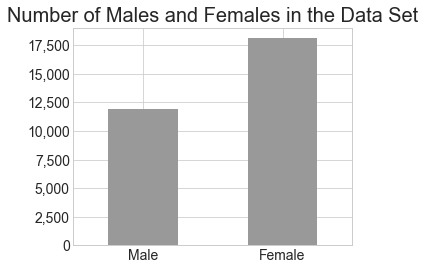

In [6]:
# Plot the number of males and females

fig, ax = plt.subplots(1, 1)

my_colors = ['0.6']

default_sex_crosstab.loc['All'][0:2].plot.bar(figsize=(5,4), 
                                              rot=0, 
                                              fontsize=14,
                                              color=my_colors, 
                                              ax=ax)

plt.title('Number of Males and Females in the Data Set', 
          fontsize=20)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.label.set_visible(False)

plt.show()

In [7]:
# Normalize the contingency table columns
# by dividing each column by the column's total.

default_sex_crosstab_norm =  default_sex_crosstab / default_sex_crosstab.loc['All']
default_sex_crosstab_norm

SEX                             Male    Female     All
default payment next month                            
Non-default                 0.758328  0.792237  0.7788
Default                     0.241672  0.207763  0.2212
All                         1.000000  1.000000  1.0000

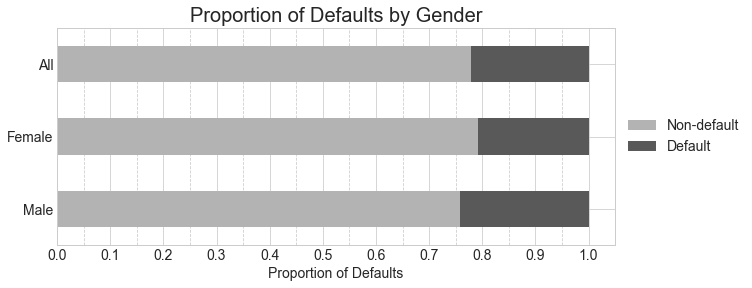

In [8]:
# Plot the proportion of defaults by gender, showing:
#   1. the proportion of defaults for males;
#   2. the proportion of defaults for females; and
#   3. the proportion of defaults for the entire data set.

fig, ax = plt.subplots(1, 1)

my_colors = ['0.7','0.35',]
default_sex_crosstab_norm[0:2].T.plot.barh(stacked=True, 
                                           figsize=(10,4), 
                                           xticks=list(np.linspace(0, 1, 11)),
                                           rot=0, 
                                           fontsize=14,
                                           color=my_colors, 
                                           ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

ax.xaxis.set_ticks(list(np.linspace(0.05, .95, 10)), minor=True)
ax.grid(b=True, which='minor', color='.8', linestyle='--')

ax.yaxis.label.set_visible(False)


plt.title('Proportion of Defaults by Gender', fontsize=20)
plt.xlabel('Proportion of Defaults', fontsize=14)

plt.show()

#### Observations:

+ For the entire data set, approximately 22.1% of the individuals defaulted.
+ Approximately 24.2% of the males defaulted.
+ Approximately 20.8% of the females defaulted.

The proportion of defaults for men is slightly higher than the proportion of defaults for women.  However, this difference appears to be small and may not be statistically significant.

#### Follow-up points:
+ Conduct a hypothesis test to check if the difference in the proportion of defaults for males and females is statistically significant.

### 2. Is the proportion of defaults the same regardless of level of education?

The data set contains information on the level of educational attainment for each individual.  There are:

+ 10,585 individuals with graduate school educations;
+ 14,030 individuals with university educations;
+ 4,917 individuals with high school educations; and
+ 468 individuals categorized as 'others'.

Below, we will check whether the proportion of defaults for each level of education is roughly the same.  Is there a trend?  Does the proportion of defaults seem to decrease (or increase) as the level of education increases?


One might expect that people with higher degrees tend to earn more than people with lower degrees, all else equal.  Therefore, there might be reason to think that the proportion of defaults would decrease as the level of education increases.

On the other hand, there are some countervailing forces that might make some people with higher degrees more likely to default, namely:
1. People with higher degrees may be saddled with more more student debt.
2. People with higher degrees may have foregone earnings for many years while pursuing their degrees.

We will look at the data to see if there appears to be any relationship between the proportion of defaults and the level of education.

In [9]:
# Create a contingency table of 
# education (Graduate school / University / High school /Others) and
# default status (default / non-default)

default_edu_crosstab = pd.crosstab(df_wrangled['default payment next month'], 
                                   df_wrangled['EDUCATION'], 
                                   margins=True,
                                   normalize=False)

# default payment next month:
# 0 = non-default; 1 = default
new_index = {0: 'Non-default', 1: 'Default', }

# EDUCATION: 
# 1 = graduate school; 2 = university; 3 = high school; 4 = others.
new_columns = {1 : 'Graduate school', 
               2 : 'University', 
               3 : 'High school', 
               4 : 'Others'}

default_edu_crosstab.rename(index=new_index, columns=new_columns, inplace=True)
default_edu_crosstab

EDUCATION                   Graduate school  University  High school  Others  \
default payment next month                                                     
Non-default                            8549       10700         3680     435   
Default                                2036        3330         1237      33   
All                                   10585       14030         4917     468   

EDUCATION                     All  
default payment next month         
Non-default                 23364  
Default                      6636  
All                         30000

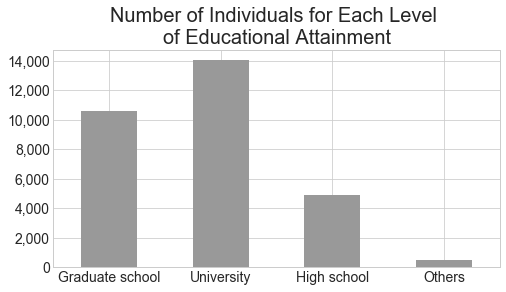

In [10]:
# Plot the number of individuals for 
# each level of educational attainment.

fig, ax = plt.subplots(1, 1)

my_colors = ['0.6']

default_edu_crosstab.loc['All'][0:4].plot.bar(figsize=(8,4), 
                                              rot=0, 
                                              fontsize=14,
                                              color=my_colors, 
                                              ax=ax)

plt.title('Number of Individuals for Each Level \nof Educational Attainment', 
          fontsize=20)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.label.set_visible(False)

plt.show()

In [11]:
# Normalize the contingency table columns
# by dividing each column by the column's total.

default_edu_crosstab_norm =  default_edu_crosstab / default_edu_crosstab.loc['All']
default_edu_crosstab_norm

EDUCATION                   Graduate school  University  High school  \
default payment next month                                             
Non-default                        0.807652    0.762651     0.748424   
Default                            0.192348    0.237349     0.251576   
All                                1.000000    1.000000     1.000000   

EDUCATION                     Others     All  
default payment next month                    
Non-default                 0.929487  0.7788  
Default                     0.070513  0.2212  
All                         1.000000  1.0000

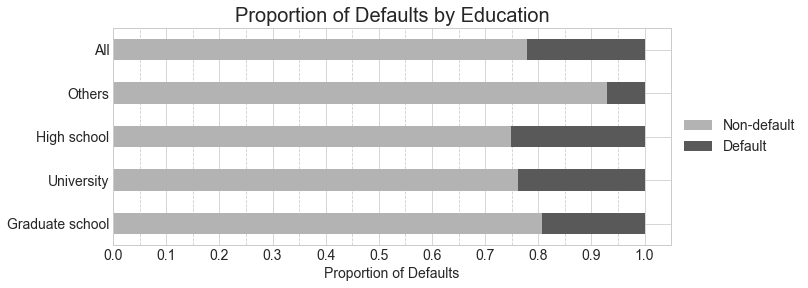

In [12]:
# Plot the proportion of defaults by level of education, showing:
#   1. the proportion of defaults for individuals with high school education;
#   2. the proportion of defaults for individuals with univeresity education;
#   3. the proportion of defaults for individuals with graduate school education;
#   4. the proportion of defaults for individuals categorized as 'others';
#   5. the proportion of defaults for the entire data set.

fig, ax = plt.subplots(1, 1)

my_colors = ['0.7','0.35',]
default_edu_crosstab_norm[0:2].T.plot.barh(stacked=True, 
                                           figsize=(10,4), 
                                           xticks=list(np.linspace(0, 1, 11)),
                                           rot=0, 
                                           fontsize=14,
                                           color=my_colors, 
                                           ax=ax)

lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

ax.xaxis.set_ticks(list(np.linspace(0.05, .95, 10)), minor=True)
ax.grid(b=True, which='minor', color='.8', linestyle='--')

ax.yaxis.label.set_visible(False)

plt.title('Proportion of Defaults by Education', fontsize=20)
plt.xlabel('Proportion of Defaults', fontsize=14)


# figure file_name
fig_file_name = 'EDA_Defaults_by_EDU'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

#### Observations:

+ The proportion of defaults seems to decrease as the level of education increases.

#### Follow-up points:
+ Conduct a hypothesis test to check if the differences in the proportion of defaults for each level of education is statistically significant.

### 3. Is the proportion of defaults the same regardless of marital status?

The data set contains information on the marital status of each individual.  There are:

+ 13,659 married individuals;
+ 15,964 single individuals;
+ 323 divorced individuals;
+ 54 individuals categorized as 'others'.

Below, we will check whether the proportion of defaults for each of these groups is roughly the same.  

One might expect that divorced individuals would be more likely to default, because:
+ The divorce process can inflict enormous legal expense;
+ Divorced individuals may have larger housing costs than married couples, since divorced individuals can no longer save on housing expenses through cohabitation with their (former) spouse.

In [13]:
# Create a contingency table of 
# marital status (Married / Single / Divorce / Others and
# default status (default / non-default)

default_mar_crosstab = pd.crosstab(df_wrangled['default payment next month'], 
                                   df_wrangled['MARRIAGE'], 
                                   margins=True,
                                   normalize=False)

# default payment next month:
# 0 = non-default; 1 = default
new_index = {0: 'Non-default', 1: 'Default', }

# MARRIAGE:
# 1 = married; 2 = single; 3 = divorce; 0=others.
new_columns = {1 : 'Married', 
               2 : 'Single', 
               3 : 'Divorce', 
               0 : 'Others'}

default_mar_crosstab.rename(index=new_index, columns=new_columns, inplace=True)
default_mar_crosstab

MARRIAGE                    Others  Married  Single  Divorce    All
default payment next month                                         
Non-default                     49    10453   12623      239  23364
Default                          5     3206    3341       84   6636
All                             54    13659   15964      323  30000

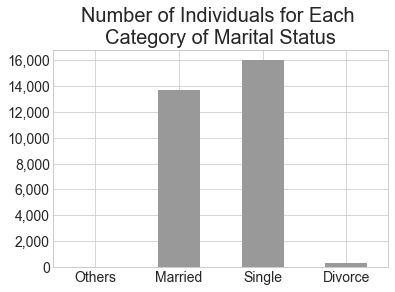

In [14]:
# Plot the number of individuals for 
# each category of marital status.

fig, ax = plt.subplots(1, 1)

my_colors = ['0.6']

default_mar_crosstab.loc['All'][0:4].plot.bar(figsize=(6,4), 
                                              rot=0, 
                                              fontsize=14,
                                              color=my_colors, 
                                              ax=ax)

plt.title('Number of Individuals for Each \nCategory of Marital Status', 
          fontsize=20)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.label.set_visible(False)

plt.show()

In [15]:
# Normalize the contingency table columns
# by dividing each column by the column's total.

default_mar_crosstab_norm =  default_mar_crosstab / default_mar_crosstab.loc['All']
default_mar_crosstab_norm

MARRIAGE                      Others   Married    Single   Divorce     All
default payment next month                                                
Non-default                 0.907407  0.765283  0.790717  0.739938  0.7788
Default                     0.092593  0.234717  0.209283  0.260062  0.2212
All                         1.000000  1.000000  1.000000  1.000000  1.0000

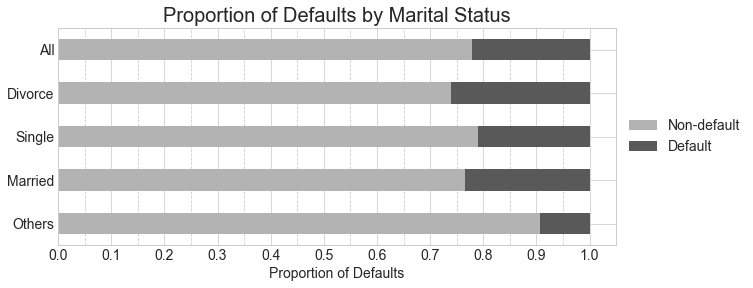

In [16]:
# Plot the proportion of defaults by marital status, showing:
#   1. the proportion of defaults for single individuals;
#   2. the proportion of defaults for married individuals;
#   3. the proportion of defaults for divorced individuals;
#   4. the proportion of defaults for individuals categorized as 'others';
#   5. the proportion of defaults for the entire data set.

fig, ax = plt.subplots(1, 1)

my_colors = ['0.7','0.35',]
default_mar_crosstab_norm[0:2].T.plot.barh(stacked=True, 
                                           figsize=(10,4), 
                                           xticks=list(np.linspace(0, 1, 11)),
                                           rot=0, 
                                           fontsize=14,
                                           color=my_colors, 
                                           ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

ax.xaxis.set_ticks(list(np.linspace(0.05, .95, 10)), minor=True)
ax.grid(b=True, which='minor', color='.8', linestyle='--')

ax.yaxis.label.set_visible(False)

plt.title('Proportion of Defaults by Marital Status', fontsize=20)
plt.xlabel('Proportion of Defaults', fontsize=14)

plt.show()

#### Observations:

+ The proportion of defaults seems to be highest for divorced individuals and lowest for single individuals (we are ignoring "Others").

The relatively high default rate among divorced individuals fits with our intuition that divorced individuals would be more likely to default, since:
+ The divorce process can inflict enormous legal expense;
+ Divorced individuals may have larger housing costs than married couples, since divorced individuals can no longer save on housing expenses through cohabitation with their (former) spouse.

#### Follow-up points:
+ Conduct a hypothesis test to check if the differences in the proportion of defaults for each category of matiral status is statistically significant.

### 4. Is the proportion of defaults correlated with age?

Below, we will check whether the proportion of defaults changes with age.

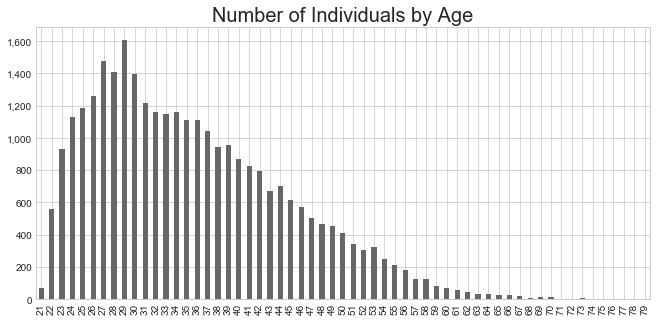

In [17]:
# Plot the number of individuals by age.

# Create series of the number of individuals by age.
age_count = df_wrangled['AGE'].value_counts().sort_index(ascending=True)

# Fill in missing age counts with zeros.
for i in list(range(age_count.index.min(), age_count.index.max()+1)):
    if i not in age_count.index:
        s = pd.Series([0], index=[i])
        age_count = age_count.append(s)

age_count.sort_index(ascending=True, inplace=True)

# Plot the Series

fig, ax = plt.subplots(1, 1)

my_colors = ['0.4']

age_count.plot.bar(figsize=(11,5), 
                   rot=90, 
                   fontsize=10,
                   color=my_colors, 
                   ax=ax)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.label.set_visible(False)

plt.title('Number of Individuals by Age', 
          fontsize=20)
plt.xlabel('Age', fontsize=14)

plt.show()

In [18]:
# Create a contingency table of age and
# default status (default / non-default)

default_age_crosstab = pd.crosstab(df_wrangled['default payment next month'], 
                                   df_wrangled['AGE'], 
                                   margins=True,
                                   normalize=False)

# default payment next month:
# 0 = non-default; 1 = default
new_index = {0: 'Non-default', 1: 'Default', }

default_age_crosstab.rename(index=new_index, inplace=True)
default_age_crosstab

AGE                         21   22   23    24    25    26    27    28    29  \
default payment next month                                                     
Non-default                 53  391  684   827   884  1003  1164  1123  1292   
Default                     14  169  247   300   302   253   313   286   313   
All                         67  560  931  1127  1186  1256  1477  1409  1605   

AGE                           30    31    32    33    34    35    36    37  \
default payment next month                                                   
Non-default                 1121   988   933   931   931   887   854   812   
Default                      274   229   225   215   231   226   254   229   
All                         1395  1217  1158  1146  1162  1113  1108  1041   

AGE                          38   39   40   41   42   43   44   45   46   47  \
default payment next month                                                     
Non-default                 750  755  683  639  609  520  538  501  413  381   
Default                     194  199  187  185  185  150  162  116  157  120   
All                         944  954  870  824  794  670  700  617  570  501   

AGE                          48   49   50   51   52   53   54   55   56   57  \
default payment next month                                                     
Non-default                 362  333  310  252  226  251  191  152  129   95   
Default                     104  119  101   88   78   74   56   57   49   27   
All                         466  452  411  340  304  325  247  209  178  122   

AGE                          58  59  60  61  62  63  64  65  66  67  68  69  \
default payment next month                                                    
Non-default                  91  62  44  35  37  23  22  19  18  11   4  12   
Default                      31  21  23  21   7   8   9   5   7   5   1   3   
All                         122  83  67  56  44  31  31  24  25  16   5  15   

AGE                         70  71  72  73  74  75  79    All  
default payment next month                                     
Non-default                  8   3   2   1   1   2   1  23364  
Default                      2   0   1   3   0   1   0   6636  
All                         10   3   3   4   1   3   1  30000

In [19]:
# Normalize the contingency table columns
# by dividing each column by the column's total.

default_age_crosstab_norm =  default_age_crosstab / default_age_crosstab.loc['All']
default_age_crosstab_norm

AGE                               21        22        23        24        25  \
default payment next month                                                     
Non-default                 0.791045  0.698214  0.734694  0.733807  0.745363   
Default                     0.208955  0.301786  0.265306  0.266193  0.254637   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               26        27        28        29        30  \
default payment next month                                                     
Non-default                 0.798567  0.788084  0.797019  0.804984  0.803584   
Default                     0.201433  0.211916  0.202981  0.195016  0.196416   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               31        32        33        34        35  \
default payment next month                                                     
Non-default                 0.811832  0.805699  0.812391  0.801205  0.796945   
Default                     0.188168  0.194301  0.187609  0.198795  0.203055   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               36        37        38        39        40  \
default payment next month                                                     
Non-default                 0.770758  0.780019  0.794492  0.791405  0.785057   
Default                     0.229242  0.219981  0.205508  0.208595  0.214943   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               41        42        43        44        45  \
default payment next month                                                     
Non-default                 0.775485  0.767003  0.776119  0.768571  0.811994   
Default                     0.224515  0.232997  0.223881  0.231429  0.188006   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               46        47        48        49        50  \
default payment next month                                                     
Non-default                 0.724561  0.760479  0.776824  0.736726  0.754258   
Default                     0.275439  0.239521  0.223176  0.263274  0.245742   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               51        52        53        54        55  \
default payment next month                                                     
Non-default                 0.741176  0.743421  0.772308  0.773279  0.727273   
Default                     0.258824  0.256579  0.227692  0.226721  0.272727   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                               56        57        58        59        60  \
default payment next month                                                     
Non-default                 0.724719  0.778689  0.745902  0.746988  0.656716   
Default                     0.275281  0.221311  0.254098  0.253012  0.343284   
All                         1.000000  1.000000  1.000000  1.000000  1.000000   

AGE                            61        62        63        64        65  \
default payment next month                                                  
Non-default                 0.625  0.840909  0.741935  0.709677  0.791667   
Default                     0.375  0.159091  0.258065  0.290323  0.208333   
All                         1.000  1.000000  1.000000  1.000000  1.000000   

AGE                           66      67   68   69   70   71        72    73  \
default payment next month                                                     
Non-default                 0.72  0.6875  0.8  0.8  0.8  1.0  0.666667  0.25   
Default                     0.28  0.3125  0.2  0.2  0.2  0.0  0.333333  0.75   
All                         1.00  1.0000  1.0  1.0  1.0  1.0  1.000000  1.00   

AGE  

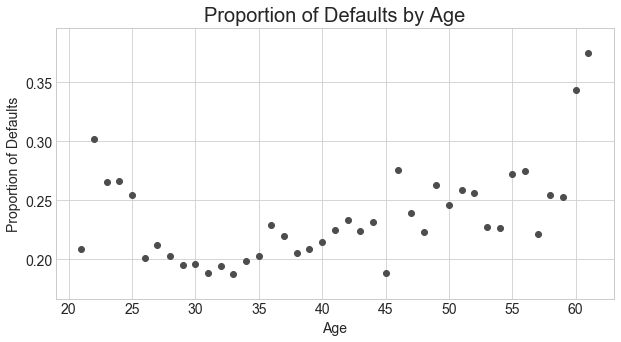

In [20]:
# Plot the proportion of defaults by age, but only
# for ages with at least 50 observations.

my_df = df_wrangled.groupby(['AGE', 
                             'default payment next month']).size().unstack()

# Filter out ages with fewer than 50 observations.
my_df = my_df[my_df.sum(axis=1)>50]

# Calculate proportions
my_df = my_df.div(my_df.sum(axis=1), axis='index')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))

my_colors = ['0.3']

ax.scatter(x=my_df.index,
           y=my_df[1], 
           color=my_colors)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

plt.title('Proportion of Defaults by Age', fontsize=20)
plt.ylabel('Proportion of Defaults', fontsize=14)
plt.xlabel('Age', fontsize=14)

# figure file_name
fig_file_name = 'EDA_Defaults_by_Age'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300)

plt.show()

#### Observations:

+ The proportion of defaults seems to be non-linearly related with age.
+ The proportion of defaults seems to decrease from the early 20s to the early 30s.
+ The proportion of defaults seems to increase from the early 30s onward.

#### Follow-up points:
+ Conduct a logistic regression where age is the predictor variable and default status is the target variable.

### 5. Is the proportion of defaults correlated with credit limit?

Below, we will check whether the proportion of defaults changes with credit limit.

In our data set the credit limit variable is defined as: 

"[The amount] of the given credit [denominated in Taiwan New Dollars]: it includes both the individual consumer credit and his/her family (supplementary) credit." 

In [21]:
# Calculate summary statistics for credit limit.

df_wrangled['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

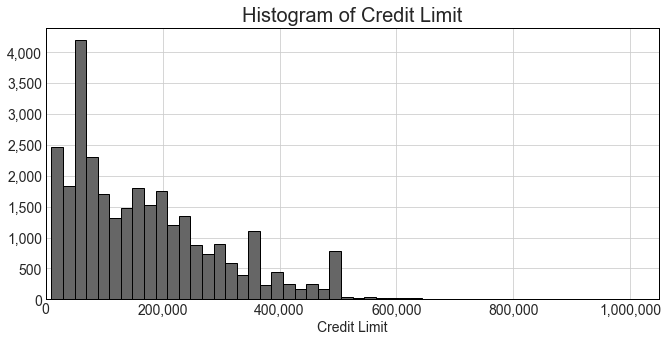

In [22]:
# Plot the a histogram of the number of individuals 
# in each credit limit bin.

fig, ax = plt.subplots(1, 1, figsize=(11,5))

my_colors = ['0.4']

df_wrangled['LIMIT_BAL'].hist(bins=50,
                              color=my_colors,
                              ax=ax, 
                              ec='k',
                              lw=1)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for spine in ax.spines.values():
    spine.set_edgecolor('k')

plt.title('Histogram of Credit Limit', 
      fontsize=20)
plt.xlabel('Credit Limit', fontsize=14)

plt.show()

In [23]:
# Define a generator that yields a range of floating point numbers.
# This will be used for binning below.

def float_range(start, stop, step=1.0):
    '''Generator that yields a range of floating point numbers'''
    while start < stop:
        yield start
        start +=step        

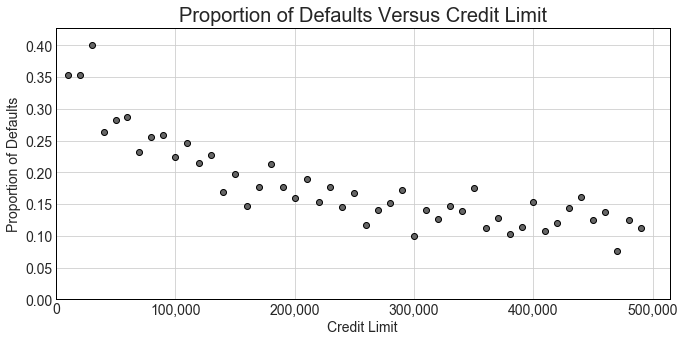

In [24]:
# Plot the proportion of defaults for each 
# credit limit bin.

# Create a list to bin credit limit observations
# The bin size is 10,000 Taiwan New Dollars.

step = 10000
start = round((df_wrangled['LIMIT_BAL'].min()), -4)
stop = round((df_wrangled['LIMIT_BAL'].max() + step), -4)
        
bins = []
for i in float_range(start, stop, step):
    bins.append(round(i,1))

group_names = bins[0:(len(bins)-1)]
group_names

# Bin the data

df_wrangled_copy = df_wrangled.copy()

categories = pd.cut(df_wrangled_copy['LIMIT_BAL'], 
                    bins=bins, 
                    labels=group_names)

df_wrangled_copy['LIMIT_BAL_BINNED'] = categories

my_df = df_wrangled_copy.groupby(['LIMIT_BAL_BINNED',
                                    'default payment next month']).size().unstack()

# Require at least 50 total observations per age
my_df = my_df[my_df.sum(axis=1)>50]

my_df = my_df.div(my_df.sum(axis=1), axis='index')
my_df.sort_index(ascending=False, inplace=True)

# Plot 

fig, ax = plt.subplots(1, 1, figsize=(11,5))

my_colors = ['0.4']

plt.scatter(x=my_df.index, y=my_df[1],
            c=my_colors,  
            edgecolors='k', 
            linewidths=1)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

def yaxis_formatter_fn(x, pos):
    return "{:,}".format(int(x))

formatter = FuncFormatter(yaxis_formatter_fn)
ax.xaxis.set_major_formatter(formatter)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for spine in ax.spines.values():
    spine.set_edgecolor('k')

plt.title('Proportion of Defaults Versus Credit Limit', 
          fontsize=20)    
plt.ylabel('Proportion of Defaults', fontsize=14)
plt.xlabel('Credit Limit', fontsize=14)


# figure file_name
fig_file_name = 'EDA_Defaults_by_Credit_Limit'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300)

plt.show()

#### Observations:

+ The proportion of defaults seems to be negatively correlated with credit limit.

Generally, only the most credit-worthy customers are eligible for increases in their credit limits.  Credit card companies appear to be doing a good job at due diligence.  Low credit limits are allowed for the least credit-worthy, and  high credit limits are allowed for the most credit-worthy.

#### Follow-up points:
+ Conduct a logistic regression where credit limit is the predictor variable and default status is the target variable.

### 6. Is the history of past repayment status predictive of the proportion of defaults?

For each observation, the data set contains payment records for the past 6 months (from April to September, 2005). There is a feature variable for each month. The variable can take on any integer value within the range of -2 to 9, where each integer stands for the following categories:

+ -2: No consumption; 
+ -1: Paid in full; 
+ 0: The use of revolving credit; 
+ 1: payment delay for one month; 
+ 2: payment delay for two months;
+ . . .; 
+ 8: payment delay for eight months; 
+ 9: payment delay for nine months and above.

Below, we will investigate how the proportion of defaults might be related to the history of past repayment status.

To do this, we do the following:

1. For each month, group observations by repayment status categories (-2, -1, ..., 8, 9);
2. Calculate of these groups, calculate the proportion of observations that ended up defaulting;
3. Plot the proportion of defaults for each month/repayment status combination.

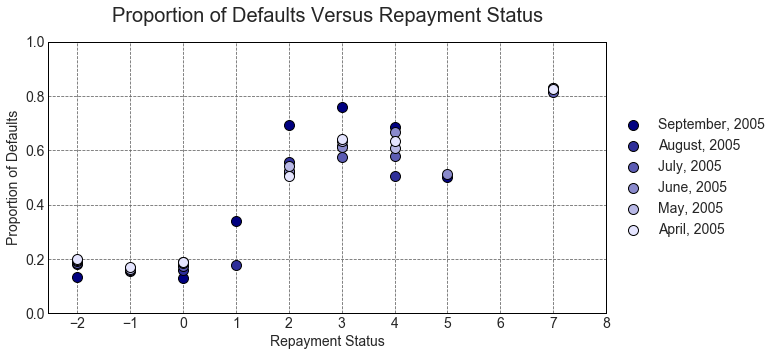

In [25]:
pay_list =['PAY_1',  'PAY_2',  'PAY_3',  'PAY_4',  'PAY_5',  'PAY_6']


label_dict ={'PAY_1': 'September, 2005', 
             'PAY_2': 'August, 2005', 
             'PAY_3': 'July, 2005', 
             'PAY_4': 'June, 2005',  
             'PAY_5': 'May, 2005',  
             'PAY_6': 'April, 2005'}

pay_dfs = {}

for item in pay_list:
    pay_dfs[item] = df_wrangled.groupby([item, 'default payment next month']).size().unstack()
    # Require at least 50 total observations
    
    pay_dfs[item] = pay_dfs[item][pay_dfs[item].sum(axis=1)>25]
    
    # Calculate proportions
    pay_dfs[item] = pay_dfs[item].div(pay_dfs[item].sum(axis=1), axis='index')
    pay_dfs[item].sort_index(ascending=False, inplace=True)
        
# plot

sns.set_palette(sns.light_palette("navy", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for item in pay_list:
    ax.scatter(x=pay_dfs[item].index, 
               y=pay_dfs[item][1],
               label=label_dict.get(item),
               s=100, 
               edgecolor='k', 
               lw=1)          
    
ax.set_ylim([0, 1])

ticks = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]#, 9]
plt.xticks(ticks, rotation=0)
#plt.xticks(x, labels, rotation='vertical')

ax.xaxis.set_ticks(ticks=ticks, minor=False)

ax.grid(b=True, which='major', color='0.4', linestyle='--')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for spine in ax.spines.values():
    spine.set_edgecolor('k')
        
sns.set_palette(sns.light_palette("navy", reverse=True))
        
#plt.title('Proportion of Defaults Versus Repayment Status', 
#          fontsize=20)  

plt.title('Proportion of Defaults Versus Repayment Status', 
          fontsize=20,
          y = 1.05) 

plt.ylabel('Proportion of Defaults', fontsize=14)
plt.xlabel('Repayment Status', fontsize=14)


# figure file_name
fig_file_name = 'EDA_Defaults_by_Repayment_Status'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

#### Observations:

+ the proportion of defaults for observations with payment delay for 2 or more months are much higher than the other observations.

### 7. Is the history of credit card bill amount predictive of the proportion of defaults?

For each observation, the data set contains bill amounts for the past 6 months (from April to September, 2005). 

Below, we will investigate how the proportion of defaults might be related to the history of past bill amounts.

To do this, we do the following:

1. Calculate the ratio of (bill amount / credit limit);
2. For each month, bin these ratios of (bill amount / credit limit) using a bin size of 0.1;
3. Plot the proportion of defaults for each month/bin combination.

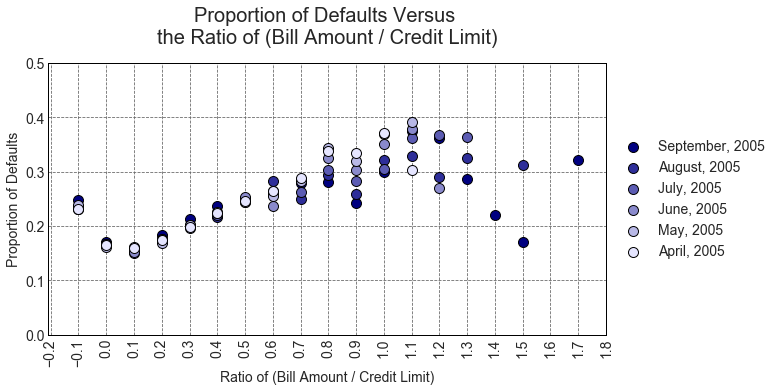

In [26]:
bill_amt_list =['BILL_AMT1', 
                'BILL_AMT2', 
                'BILL_AMT3', 
                'BILL_AMT4', 
                'BILL_AMT5', 
                'BILL_AMT6']

label_dict ={'BILL_AMT1': 'September, 2005',  
             'BILL_AMT2': 'August, 2005',
             'BILL_AMT3': 'July, 2005', 
             'BILL_AMT4': 'June, 2005',  
             'BILL_AMT5': 'May, 2005', 
             'BILL_AMT6': 'April, 2005'}

c_dict ={'BILL_AMT1': 'BILL_AMT1_OVER_LIMIT_BAL',  
         'BILL_AMT2': 'BILL_AMT2_OVER_LIMIT_BAL', 
         'BILL_AMT3': 'BILL_AMT3_OVER_LIMIT_BAL',  
         'BILL_AMT4': 'BILL_AMT4_OVER_LIMIT_BAL', 
         'BILL_AMT5': 'BILL_AMT5_OVER_LIMIT_BAL',  
         'BILL_AMT6': 'BILL_AMT6_OVER_LIMIT_BAL'}

c_dict_binned ={'BILL_AMT1': 'BILL_AMT1_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT2': 'BILL_AMT2_OVER_LIMIT_BAL_BINNED', 
                'BILL_AMT3': 'BILL_AMT3_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT4': 'BILL_AMT4_OVER_LIMIT_BAL_BINNED', 
                'BILL_AMT5': 'BILL_AMT5_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT6': 'BILL_AMT6_OVER_LIMIT_BAL_BINNED'}

df_wrangled_copy = df_wrangled.copy()

for item in bill_amt_list:
    df_wrangled_copy[c_dict.get(item)] = df_wrangled_copy[item].div(df_wrangled_copy['LIMIT_BAL'],
                                                                              axis='index')

min_set = set()
max_set = set()

for item in bill_amt_list:
    min_set.add(df_wrangled_copy[c_dict.get(item)].min())
    max_set.add(df_wrangled_copy[c_dict.get(item)].max())
    
step = 0.1
    
start = round((min(min_set) - step), 1)
stop = round((max(max_set) + step), 1)

bins = []
for i in float_range(start, stop, step):
    bins.append(round(i,1))

group_names = bins[0:(len(bins)-1)]
group_names

for item in bill_amt_list:
    categories = pd.cut(df_wrangled_copy[c_dict.get(item)], 
                        bins=bins, 
                        labels=group_names)
    df_wrangled_copy[c_dict_binned.get(item)] = categories

bill_amt_dfs = {}

for item in bill_amt_list:
    bill_amt_dfs[item] = df_wrangled_copy.groupby([c_dict_binned.get(item), 
                                                   'default payment next month']).size().unstack()
    # Require at least 50 total observations
    
    bill_amt_dfs[item] = bill_amt_dfs[item][bill_amt_dfs[item].sum(axis=1)>25]
    
    # Calculate proportions
    bill_amt_dfs[item] = bill_amt_dfs[item].div(bill_amt_dfs[item].sum(axis=1), axis='index')
    bill_amt_dfs[item].sort_index(ascending=False, inplace=True)
        
# plot

sns.set_palette(sns.light_palette("navy", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for item in bill_amt_list:
    ax.scatter(x=bill_amt_dfs[item].index, 
               y=bill_amt_dfs[item][1],
               label=label_dict.get(item),
               s=100, 
               edgecolor='k', 
               lw=1)          
    
ax.set_ylim([0, 0.5])

xmin, xmax = ax.get_xlim()

step = 0.1
start = round((xmin), 1)
stop = round((xmax + step), 1)

ticks = []
for i in float_range(start, stop, step):
    ticks.append(round(i,1))

plt.xticks(ticks, rotation=90)

ax.grid(b=True, which='major', color='0.4', linestyle='--')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for spine in ax.spines.values():
    spine.set_edgecolor('k')
        
sns.set_palette(sns.light_palette("navy", reverse=True))
        
#plt.title('Proportion of Defaults Versus \nthe Ratio of (Bill Amount / Credit Limit)', 
#          fontsize=20)    

plt.title('Proportion of Defaults Versus \nthe Ratio of (Bill Amount / Credit Limit)', 
          fontsize=20,
          y = 1.05)   

plt.ylabel('Proportion of Defaults', fontsize=14)
plt.xlabel('Ratio of (Bill Amount / Credit Limit)', fontsize=14)


# figure file_name
fig_file_name = 'EDA_Defaults_by_ratio_bacl'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

#### Observations:

+ The proportion of defaults seems to be positively correlated with the ratio of (bill amount / credit limit).

#### Follow-up points:
+ Conduct a logistic regression where the ratio of (bill amount / credit limit) is the predictor variable and default status is the target variable.

### 8. Is the ratio of ((bill amount - pay amount) / credit limit) predictive of the proportion of defaults?

To investigate this relationship, we do the following:

1. Calculate the ratio of ((bill amount - pay amount) / credit limit);
2. For each month, bin these ratios of ((bill amount - pay amount) / credit limit) using a bin size of 0.1;
3. Plot the proportion of defaults for each month/bin combination.

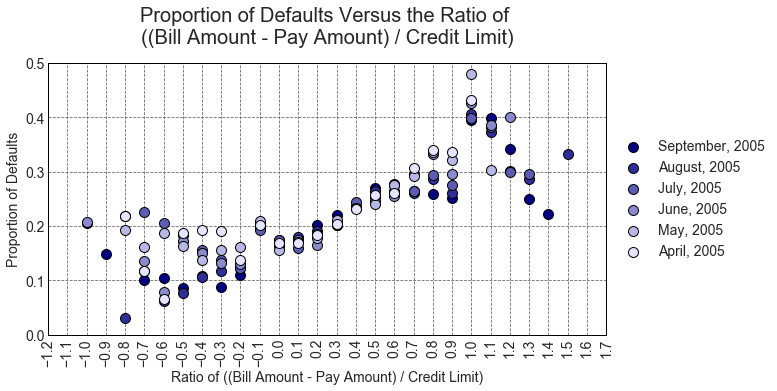

In [27]:
bill_amt_list =['BILL_AMT1', 
                'BILL_AMT2', 
                'BILL_AMT3', 
                'BILL_AMT4', 
                'BILL_AMT5', 
                'BILL_AMT6']

bill_pay_dict ={'BILL_AMT1': 'PAY_AMT1',  
                'BILL_AMT2': 'PAY_AMT2', 
                'BILL_AMT3': 'PAY_AMT3',  
                'BILL_AMT4': 'PAY_AMT4',  
                'BILL_AMT5': 'PAY_AMT5', 
                'BILL_AMT6': 'PAY_AMT6'}

label_dict ={'BILL_AMT1': 'September, 2005',  
             'BILL_AMT2': 'August, 2005',
             'BILL_AMT3': 'July, 2005', 
             'BILL_AMT4': 'June, 2005',  
             'BILL_AMT5': 'May, 2005', 
             'BILL_AMT6': 'April, 2005'}

c_dict ={'BILL_AMT1': 'BILL_AMT1_OVER_LIMIT_BAL',  
         'BILL_AMT2': 'BILL_AMT2_OVER_LIMIT_BAL', 
         'BILL_AMT3': 'BILL_AMT3_OVER_LIMIT_BAL',  
         'BILL_AMT4': 'BILL_AMT4_OVER_LIMIT_BAL', 
         'BILL_AMT5': 'BILL_AMT5_OVER_LIMIT_BAL',  
         'BILL_AMT6': 'BILL_AMT6_OVER_LIMIT_BAL'}

c_dict_binned ={'BILL_AMT1': 'BILL_AMT1_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT2': 'BILL_AMT2_OVER_LIMIT_BAL_BINNED', 
                'BILL_AMT3': 'BILL_AMT3_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT4': 'BILL_AMT4_OVER_LIMIT_BAL_BINNED', 
                'BILL_AMT5': 'BILL_AMT5_OVER_LIMIT_BAL_BINNED',  
                'BILL_AMT6': 'BILL_AMT6_OVER_LIMIT_BAL_BINNED'}

df_wrangled_copy = df_wrangled.copy()

for item in bill_amt_list:
    df_wrangled_copy[c_dict.get(item)] = (df_wrangled_copy[item] - df_wrangled_copy[bill_pay_dict.get(item)]).div(df_wrangled_copy['LIMIT_BAL'],
                                                                                                                  axis='index')

min_set = set()
max_set = set()

for item in bill_amt_list:
    min_set.add(df_wrangled_copy[c_dict.get(item)].min())
    max_set.add(df_wrangled_copy[c_dict.get(item)].max())
    
step = 0.1
    
start = round((min(min_set) - step), 1)
stop = round((max(max_set) + step), 1)

bins = []
for i in float_range(start, stop, step):
    bins.append(round(i,1))

group_names = bins[0:(len(bins)-1)]
group_names

for item in bill_amt_list:
    categories = pd.cut(df_wrangled_copy[c_dict.get(item)], 
                        bins=bins, 
                        labels=group_names)
    df_wrangled_copy[c_dict_binned.get(item)] = categories

bill_amt_dfs = {}

for item in bill_amt_list:
    bill_amt_dfs[item] = df_wrangled_copy.groupby([c_dict_binned.get(item), 
                                                   'default payment next month']).size().unstack()
    # Require at least 50 total observations
    
    bill_amt_dfs[item] = bill_amt_dfs[item][bill_amt_dfs[item].sum(axis=1)>25]
    
    # Calculate proportions
    bill_amt_dfs[item] = bill_amt_dfs[item].div(bill_amt_dfs[item].sum(axis=1), axis='index')
    bill_amt_dfs[item].sort_index(ascending=False, inplace=True)
        
# plot

sns.set_palette(sns.light_palette("navy", reverse=True))

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for item in bill_amt_list:
    ax.scatter(x=bill_amt_dfs[item].index, 
               y=bill_amt_dfs[item][1],
               label=label_dict.get(item),
               s=100, 
               edgecolor='k', 
               lw=1)          
    
ax.set_ylim([0, 0.5])

xmin, xmax = ax.get_xlim()

step = 0.1
start = round((xmin), 1)
stop = round((xmax + step), 1)

ticks = []
for i in float_range(start, stop, step):
    ticks.append(round(i,1))

plt.xticks(ticks, rotation=90)

ax.grid(b=True, which='major', color='0.4', linestyle='--')

lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for spine in ax.spines.values():
    spine.set_edgecolor('k')
        
sns.set_palette(sns.light_palette("navy", reverse=True))
        
#plt.title('Proportion of Defaults Versus the Ratio of \n((Bill Amount - Pay Amount) / Credit Limit)', 
#          fontsize=20)     

plt.title('Proportion of Defaults Versus the Ratio of \n((Bill Amount - Pay Amount) / Credit Limit)', 
          fontsize=20,
          y = 1.05)     

plt.ylabel('Proportion of Defaults', fontsize=14)
plt.xlabel('Ratio of ((Bill Amount - Pay Amount) / Credit Limit)', fontsize=14)


# figure file_name
fig_file_name = 'EDA_Defaults_by_ratio_bapacl'

# figure file_path
fig_path = os.path.join(figures_dir,
                        fig_file_name)

# Save the figure
plt.savefig(fig_path, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

#### Observations:

+ The proportion of defaults seems to be positively correlated with the ratio of ((bill amount - pay amount) / credit limit).

#### Follow-up points:
+ Conduct a logistic regression where the ratio of ((bill amount - pay amount) / credit limit) is the predictor variable and default status is the target variable.